# Breast Cancer Gene Expression Predictor updated
by mikeph_

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt


# Load expression data (ignore GEO header lines)
expr = pd.read_csv(
    "data/GSE45827_series_matrix.txt",
    sep="\t",
    comment="!",
    index_col=0
)

# Transpose: samples × genes
X = expr.T

# Convert to numeric
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.mean())

print("Expression shape:", X.shape)

labels = []

with open("data/GSE45827_series_matrix.txt") as f:
    for line in f:
        if line.startswith("!Sample_characteristics_ch1"):
            values = line.strip().split("\t")[1:]
            for v in values:
                if ("cancer" in v.lower()) or ("tumor" in v.lower()):
                    labels.append(1)
                else:
                    labels.append(0)
            break  # IMPORTANT: stop after first matching line

y = np.array(labels)

print("Labels length:", len(y))
assert X.shape[0] == y.shape[0], \
    f"Mismatch: {X.shape[0]} samples vs {y.shape[0]} labels"

print("Samples and labels aligned")


Expression shape: (155, 29873)
Labels length: 155
Samples and labels aligned


## Train Model

In [20]:
# Train function
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

selector = SelectKBest(score_func=f_classif, k=200)

X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

print("Selected features:", X_train_sel.shape[1])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver="saga",
    l1_ratio=0.5,   # elastic net
    C=0.5,
    max_iter=10000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

Selected features: 200


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.5
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.5
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Evaluation

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC:", scores.std())

#permutation test
from sklearn.model_selection import permutation_test_score

score, perm_scores, pvalue = permutation_test_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    scoring="roc_auc",
    cv=cv,
    n_permutations=100,
    random_state=42
)

print("Permutation ROC-AUC:", score)
print("Permutation p-value:", pvalue)

# leave one out test
from sklearn.model_selection import LeaveOneOut, cross_val_score

loo = LeaveOneOut()

acc_scores = cross_val_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    cv=loo,
    scoring="accuracy"
)

print("LOOCV accuracy:", acc_scores.mean())




CV ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0
Std ROC-AUC: 0.0
Permutation ROC-AUC: 1.0
Permutation p-value: 0.009900990099009901
LOOCV accuracy: 0.9935483870967742


## Gene Expression

In [22]:
selected_genes = X.columns[selector.get_support()]
coef = model.coef_[0]

gene_importance = (
    pd.DataFrame({
        "Gene": selected_genes,
        "Weight": coef
    })
    .sort_values("Weight", ascending=False)
)

gene_importance.head(10)


,Gene,Weight
31,1559612_at,0.197923
62,1569760_at,0.190859
81,209006_s_at,0.189255
127,226663_at,0.178307
107,216834_at,0.167311
171,239251_at,0.163855
69,202803_s_at,0.158573
83,209201_x_at,0.151164
74,204174_at,0.150717
199,37892_at,0.147803


## Export Data

In [14]:
X.to_csv("output/expression_matrix.csv")

labels_df = pd.DataFrame({
    "sample_id": X.index,
    "label": y
})
labels_df.to_csv("output/labels.csv", index=False)

X_selected = X[selected_genes]
X_selected.to_csv("output/expression_selected_genes.csv")

gene_importance.to_csv("output/important_genes.csv", index=False)


## ROC and PCA

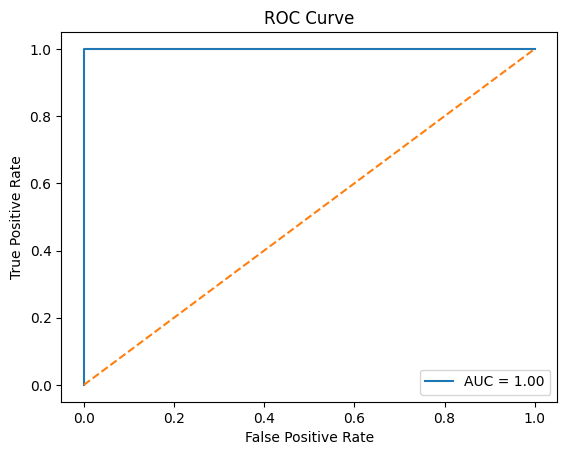

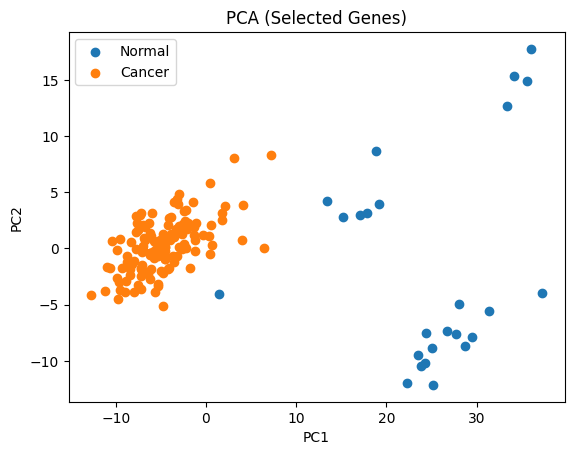

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

X_all_sel = selector.transform(X)
X_all_scaled = scaler.transform(X_all_sel)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

plt.figure()
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label="Normal")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label="Cancer")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (Selected Genes)")
plt.legend()
plt.show()

